In [41]:
import numpy as np
import networkx as nx
from gensim.models import Word2Vec
import random
import networkx as nx
import matplotlib.pyplot as plt
from scipy.sparse import *
from tqdm import tqdm
from sklearn.manifold import TSNE

In [4]:
def alpha(t, x, p, q, data_graph):
    """
    param:
    
    Input:
        @t: int, node index
        @x: int, node index
        @p: float, return factor
        @q: float, go futher factor
        @data_graph: matrix representation for graph
        
    Output:
        @rtype: float
    """
    if t == x:
        return 1.0/p
    elif data_graph[t, x] != 0:
        return 1
    else:
        return 1.0/q

def random_walk(start, p, q, sequence_length, data_graph):
    sequence = []
    for step in range(sequence_length):
        if step == 0:
            sequence.append(start)
        elif step == 1:
            current = data_graph[sequence[step-1],:].toarray().flatten()
            if sum(current) != 0:
                sequence.append(np.random.choice(range(data_graph.shape[1]), p=current/np.linalg.norm(current, ord=1)))
            else:
                sequence.append(sequence[step-1])
        else:
            current = data_graph[sequence[step-1],:].toarray().flatten()
            if sum(current) != 0:
                past = sequence[step-2]
                pi_list = []
                for i in range(data_graph.shape[1]):
                    if current[i] != 0:
                        pi_list.append(alpha(past, i, p, q, data_graph)*current[i])
                    else:
                        pi_list.append(0)
                sequence.append(np.random.choice(range(data_graph.shape[1]), p=pi_list/np.linalg.norm(pi_list, ord=1)))
            else:
                sequence.append(sequence[step-1])
    return sequence

In [7]:
# read edge data from txt file and store it as csr_matrix
with open("../Data/graph.txt") as f:
    edges = f.readlines()
rows = []
cols = []
data = []
biggest_node_index = 0
for edge in edges:
    row, col = edge.strip().split()
    rows.append(int(row)-1)
#     rows.append(int(col)-1)
    cols.append(int(col)-1)
#     cols.append(int(row)-1)
    data.append(1)
    biggest_node_index = max([max([int(row), int(col)]), biggest_node_index])
data_graph = coo_matrix((data, (rows, cols)), shape=(biggest_node_index, biggest_node_index)).tocsr()

In [15]:
# set some hyperparameter
p=0.5
q=1
num_text = 1000
sequence_length = 32
num_nodes = data_graph.shape[0]
emb_size = 200
lr = 0.1
batch_size = None
context_size = 10
num_epoch = 50
num_sampled = data_graph.shape[0]

In [11]:
# Sampling
corpus = []
for i in tqdm(range(num_text)):
    start = np.random.choice(range(num_nodes))
    corpus.append(random_walk(start, p, q, sequence_length, data_graph))

100%|██████████| 1000/1000 [00:04<00:00, 202.27it/s]


In [17]:
walks = [list(map(str, walk)) for walk in corpus]

In [18]:
model = Word2Vec(walks, size=emb_size, window=context_size, min_count=0, sg=1, workers=8, iter=1)

In [19]:
model

In [39]:
EMB = []
for i in range(12):
    EMB.append(model[str(i)])

In [42]:
low_manifest = TSNE().fit_transform(EMB)

In [43]:
low_manifest.shape

(12, 2)

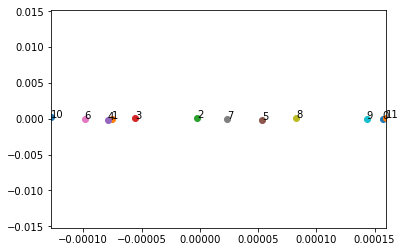

In [48]:
for i in range(len(low_manifest)):
    plt.scatter(low_manifest[i][0], low_manifest[i][1])
    plt.text(low_manifest[i][0], low_manifest[i][1], str(i))
plt.xlim([min(low_manifest[:,0]), max(low_manifest[:,0])])
# plt.ylim([min(low_manifest[:,1]), min(low_manifest[:,1])])
plt.show()

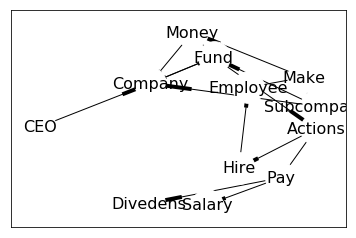

In [49]:
# Visualize the Graph
id_to_name = ['Company', 'Fund', 'Subcompany', 'CEO', 'Actions', 'Make', 'Pay', 'Hire', 'Divedens', 'Salary', 'Employee', 'Money']
name_to_id = {}
for idx, name in enumerate(id_to_name):
    name_to_id[name] = idx
labels = {}
for idx, name in enumerate(id_to_name):
    labels[idx] = name
G = nx.DiGraph(data_graph.toarray())
pos = nx.spring_layout(G)
new_pos = {}
nx.draw_networkx_nodes(G, pos, node_color="w", node_size=1000)
nx.draw_networkx_edges(G, pos, width=1)
nx.draw_networkx_labels(G, pos ,labels=labels, font_size=16, font_color="black")
plt.xticks([])
plt.yticks([])
plt.show()

In [52]:
def is_to(A, B, C, model, name_to_id, id_to_name):
    # A is to B as C is to ?
    output = model.wv.most_similar(positive=[str(name_to_id[C]), str(name_to_id[B])], negative=[str(name_to_id[A])])
    return list(map(lambda x:(id_to_name[int(x[0])], x[1]), output))

In [58]:
def is_to_cos(A, B, C, model, name_to_id, id_to_name):
    # A is to B as C is to ?
    output = model.wv.most_similar_cosmul(positive=[str(name_to_id[C]), str(name_to_id[B])], negative=[str(name_to_id[A])])
    return list(map(lambda x:(id_to_name[int(x[0])], x[1]), output))

In [57]:
is_to('Hire', 'Employee', 'Pay', model, name_to_id, id_to_name)

[('CEO', 0.8009768724441528),
 ('Subcompany', 0.7676749229431152),
 ('Divedens', 0.7002687454223633),
 ('Salary', 0.6097944974899292),
 ('Actions', 0.5863217115402222),
 ('Make', 0.4980640411376953),
 ('Money', 0.4920761287212372),
 ('Fund', 0.48745089769363403),
 ('Company', 0.4607894718647003)]

In [60]:
is_to_cos('Subcompany', 'Actions', 'Pay', model, name_to_id, id_to_name)

[('Divedens', 0.9080806970596313),
 ('CEO', 0.8925138115882874),
 ('Employee', 0.8575921654701233),
 ('Hire', 0.8183927536010742),
 ('Make', 0.8159204721450806),
 ('Money', 0.815165638923645),
 ('Fund', 0.8122068643569946),
 ('Company', 0.8071900010108948),
 ('Salary', 0.6689978241920471)]